# Preprocessing

## Load, clean and structure the conversation data

The conversation data is stored in .csv files containing conversation logs.

We'll create a dataframe containing the messages sent by the child by looping

 through the files, cleaning and storing messages sent between hints.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob
import seaborn as sns
import re
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

OriginalData = False

### ------------------------ Util functions -------------------------
# does a word include a question mark?
def hasQuestionmark(inputString):
    return int(any(char == "?" for char in inputString))

# does it include a number?
def hasNumbers(inputString):
    return int(any(char.isdigit() for char in inputString))

def clean_word(word):
    # Takes in a word and cleans it
    
    # if it's a digit - just return it
    if word.isdigit():
        return word

    # if it contains a question mark, store it and paste it in the end
    incl_question = any(char == "?" for char in word)

    # lower case
    word = word.lower() 

    # remove symbols
    word = re.sub('[^a-zA-Z]', '', word)

    # fixing typos
    if word in ['ii']:
        word = "i"
    if word in ["donyt"]:
        word = "dont"
    if word in ["okay"]: 
        word = "ok"
    if word in ['iike']:
        word = 'like'
    if word in ['multipulcation']: #, 'multiplied']:
        word = 'multiplication'
    if word in ['???']:
        word = '?'
    if word in ['stoies']:
        word = 'stories'
    if word in ['continiue']:
        word = 'continue'
    if word in ['anwser']:
        word = 'answer'
    if word in ['ithink']:
        word = 'think'
    if word in ['one']:
        word = '1'
    if word in ['knowlegde']:
        word = 'knowledge'
    
    # adding the question mark back if there was one
    word += "?"*incl_question
    
    return word

def addMessage(D, h, n, q, m):
    # adds cumulated messages m, under (hint, name, question) triplet, in dict D

    # handling different label format
    try:
        q = int(q)
    except ValueError:
        q = int(q[0])
        h = int(h)

    if h not in D: 
        # init triplet in dict
        D[(h,n,q)] = list()

    # clean every word in the c
    cw = [clean_word(m_i) for m_i in m]
    D[(h,n,q)].append(list(filter(lambda w: w!='', cw)))

def read_conv(D, f, type):
    if type == "csv":
        conv = pd.read_csv(f)
    elif type == "xlsx":
        conv = pd.read_excel(f) 
    conv = conv.replace(np.nan, '', regex=True)
    name_ = str((f.split("/")[-1]).split(".")[0])
    name = name_.replace( "_", ' ').lower()
    m = []
    hq_added = []
    for row in range(conv.shape[0]):
        if conv['sender'][row] == 'child':
            # only add messages from kid
            m = m + conv['payload'][row].split()
        hint = conv[' "Hint"'][row]
        question = conv[' "Question"'][row]
        if hint != "" and not (hint,question) in hq_added:
            # if a hint is given, store the "conversation" since last hint
            addMessage(D, hint, name, question, m) 
            m = []
            hq_added.append((hint,question)) # don't repeat hints for same child
  
    return D

### Read the data

In [3]:
# Store conversations in one dictionary
C = dict()

if OriginalData:
    # Read conversation of real data
    print("Reading original data...")
    path = "./Chat_History_Labeled"
    files = glob.glob(path + "/*.csv")
    for f in files:
        C = read_conv(C, f, "csv")
else:
    # Read conversation of simulated data
    print("Reading simulated data...")
    sim_path = "./Simulated_Data"
    sim_files = glob.glob(sim_path + "/*.csv")
    for sf in sim_files:
        C = read_conv(C, sf, "csv")

# Create a datframe with lists as x
df = pd.DataFrame(columns=['Name', 'words', 'hint'])
for hnq in C.keys():
    for x in C[hnq]:
        df = df.append({'Name': hnq[1], 'Question': hnq[2], 'words': x, 'hint': int(hnq[0])}, ignore_index=True)

df.head()

Reading simulated data...


,Name,words,hint,Question
0,test1234 3,"[where, do, i, start?]",1,2.0
1,test1234 3,"[i, am, not, sure, what, to, do, with, the, ch...",2,2.0
2,test1234 3,"[what, is, the, pencil, good, for?, i, do, not...",3,2.0
3,test1234 3,"[ok, i, think, i, can, fit, 15]",4,2.0
4,test1234 2,"[how, do, i, start]",1,2.0


## Create previous hint parameter

It's obvious that the last hint given should be a good indicator for the hint to give.

Here we extract that feature.

In [4]:
def get_prev_hint(df):
    df['prev_hint'] = 0
    # loop through names
    names = df.Name.unique()
    for name in names:
        df_forn = df[df.Name == name]
        # set prev_hint for each question
        questions = df_forn.Question.unique()
        for qu in questions:
            df_forn.loc[df_forn.Question == qu, 'prev_hint'] = df_forn.loc[df_forn.Question == qu, 'hint'].shift(1).fillna(0)
            df.loc[df.Name == name,:] = df_forn
    return df

df = get_prev_hint(df)



## Concat with child meta data

We have access to the children's demographic data such as age and math pre 

score. Here we load the data and concat it with the messages dataframe.

In [5]:
# read file
if OriginalData:
    meta_data = pd.read_excel("/kids_scores.xlsx")
else:
    meta_data = pd.read_excel("./simulated_scores.xlsx")

features = ['Name', 'Grade', 'Gender', 'Total Pre']
meta_data = meta_data[features]

# reformat
meta_data = meta_data.assign(
    Name = lambda dataframe: dataframe['Name'].map(lambda name: name.lower()),
    Grade = lambda dataframe: dataframe['Grade'].map(lambda grade: int(grade[6])),
    Gender = lambda dataframe: dataframe['Gender'].map(lambda gender: 1 if gender == "Boy" else 0)
)

# no meta data on ----- :(  ... add means of score and grade
meta_names = list(meta_data['Name'])
df_names = sorted(set(df['Name']))
missing_names = np.setdiff1d(df_names, meta_names)
if len(missing_names) > 0:
    print("Meta data missing for:", missing_names)
    ethan_data = {
        'Name': "------",
        'Grade': int(round(np.mean(list(meta_data['Grade'])))),
        'Gender': 1,
        'Total Pre': int(round(np.mean(list(meta_data['Total Pre']))))
    }
    meta_data = meta_data.append(ethan_data, ignore_index=True)

# merge
df = meta_data.merge(df, on="Name", suffixes=('', ''))
df.head()

,Name,Grade,Gender,Total Pre,words,hint,Question,prev_hint
0,test34 1,3,0,6,"[i, think, i, get, it, but, what, do, i, do, w...",3,2.0,0
1,test34 1,3,0,6,"[ah, the, video, helps, i, think, i, can, fit,...",4,2.0,3
2,test34 2,4,0,6,"[the, pencil, is, not, really, clear, to, me]",3,2.0,0
3,test34 2,4,0,6,"[ok, 20]",4,2.0,3
4,test34 3,5,1,7,"[what, does, this, pencil, do, though?, i, do,...",3,2.0,0


## NLP

One of the main goals in the project is to find out if we can use the natural 

language input from the students to infer what their confusion is and hence,

provide the correct hint. 

### Adding basic NLP features

Here we first do a few basic methods for extracting information about the NL 

input. Namely create features for number of words, indicators for the messages 

including a question and same for numbers.

In [6]:
df['incl_question'] = [hasQuestionmark("".join(df['words'][i])) for i in range(df.shape[0])] # includes a question
df['incl_number'] = [hasNumbers(df['words'][i]) for i in range(df.shape[0])] # includes a number
df['nWords'] = [len(df['words'][i]) for i in range(df.shape[0])] # number of words
df['nWords'] = np.log(df['nWords']+1) # log transformation of nWords

### Bag-Of-Words (BOW)

One way of encoding the messages is to use bag of words.

Here we create n_total_words number of features for each observation where 

each feature is an integer representing how often the word was said by the 

child for that observation. We then drop all words that were only said once

as they should not add any information to other observation using this encoding.


In [7]:
import copy

# Bag of words
def BOW(df_words, prefix="w_"):
    """
    takes in data frame with one colomn as "words" where each variable is a list
    of words transforms the dataframe into BOW version of it
    """
    n = len(df_words)

    # create a set of all words mentioned 
    words = set() 
    for i in range(n):
        for j in range(len(df_words[i])):
            df_words[i][j] = re.sub('[^a-zA-Z]', '', df_words[i][j])   # remove symbols
            words.add(df_words[i][j])

    # init counter
    D = dict()
    for w in words:
        D[w] = np.zeros(n) 

    # counting
    for row in range(len(df_words)):
        for w in df_words[row]:
            D[w][row] += 1

    # returning pd DF of BOW
    df_result = pd.DataFrame(D)
    df_result = df_result.rename(columns=lambda x: 'w_'+str(x))
    
    return df_result

# Drop words that only appear once
def drop_singles(DF):
    df_out = DF.copy()
    features = df_out.columns
    singles = []
    for f in features:
        if df_out[f].sum() == 1:
            singles.append(f)
    df_out = DF.drop(singles, axis=1)
    return df_out

df_words = copy.deepcopy(np.array(df.words))
BOW_features = BOW(df_words)
BOW_features = drop_singles(BOW_features)
BOW_features.head()

,w_ah,w_,w_to,w_start,w_what,w_am,w_sure,w_dont,w_pencil,w_interesting,...,w_oh,w_helps,w_but,w_understanding,w_in,w_this,w_chocolate,w_doing,w_really,w_correct
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Word-2-Vec

Another way to encode the words said by the sudent is word-2-vec. Here we encode the words said by the children in 300-dimensional vector space using a word-2-vec model from [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) trained on google news data. To get a meaning from messages sent by the children, the word representations for each sentence is averaged.
Uncomment the first two lines to download the gensim data.


In [10]:
### Uncommment to load google dataset
# import gensim.downloader
# wv =  gensim.downloader.load('word2vec-google-news-300')

# clear the data of numbers and "?"
filtered_words = []
for i in range(df.shape[0]):
    w = df['words'][i]
    out = [re.sub('[^a-zA-Z]', '', w_i) for w_i in w]
    filtered_words.append(out)
df_words = np.array(filtered_words)

# NOTE 5% of our words can't be evaluated with this data set:
words = set()
for i in range(df.shape[0]):
    for j in df_words[i]:
        words.add(j)
print(np.mean([w in wv.vocab for w in words]))

# calculate 300 dimensional word vectors for each word
nrows = df.shape[0]
vec = np.zeros((df.shape[0],300))
unfound_words = set()
for i in range(nrows):
    counter = 0
    for s in df_words[i]:
        if s == '':
            continue
        if s in wv.vocab:
            counter += 1
            vec[i,:] = ((counter-1)*vec[i,:] + wv[s])/counter # average
            # vec[i,:] += wv[s] # sum
        else:
            unfound_words.add(s)
print("WARNING words not found:", unfound_words)

def pca_reduction(WV_model, p_WV):
    """
    Function that takes in a W2V feature representation and
    a number of dimension to reduce to. Returns set of features
    in that vector space.
    """
    pca = PCA(n_components=p_WV).fit(WV_model)
    WV_features = pd.DataFrame(pca.transform(WV_model))
    WV_features = WV_features.rename(columns=lambda x: 'WV_'+str(x))
    return WV_features


0.9453125
WARNING words not found: {'to', 'a', 'of', 'jeej', 'pensil', 'and'}


## Visualization


### Variables

Visualizing correlation between our variables, excluding word representations and including the response.

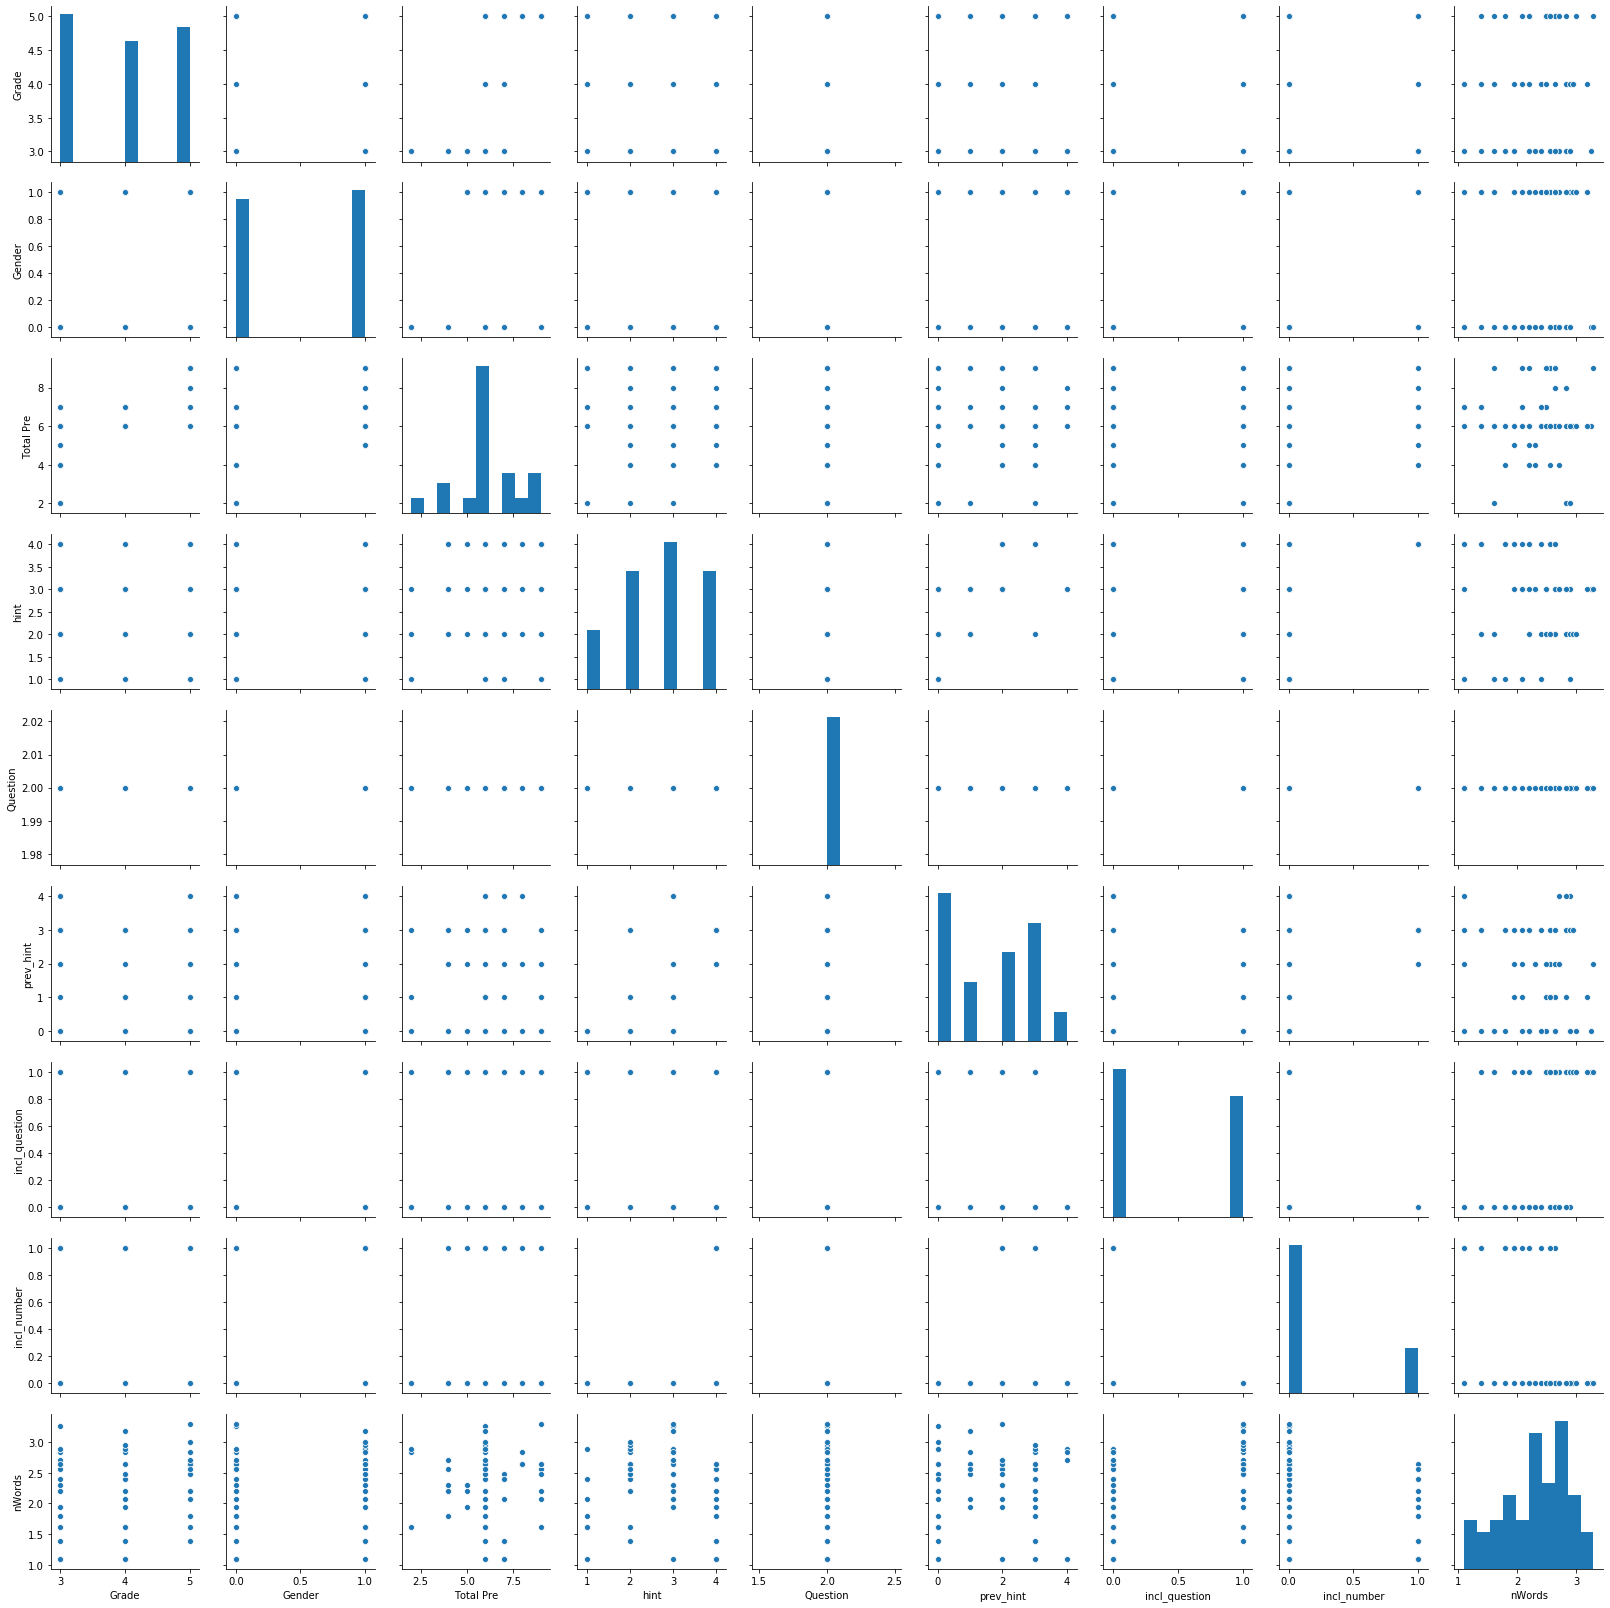

In [11]:
sns.pairplot(df)

### Word-2-vec

Here we visualize how the vector space of messages maps in 2D.

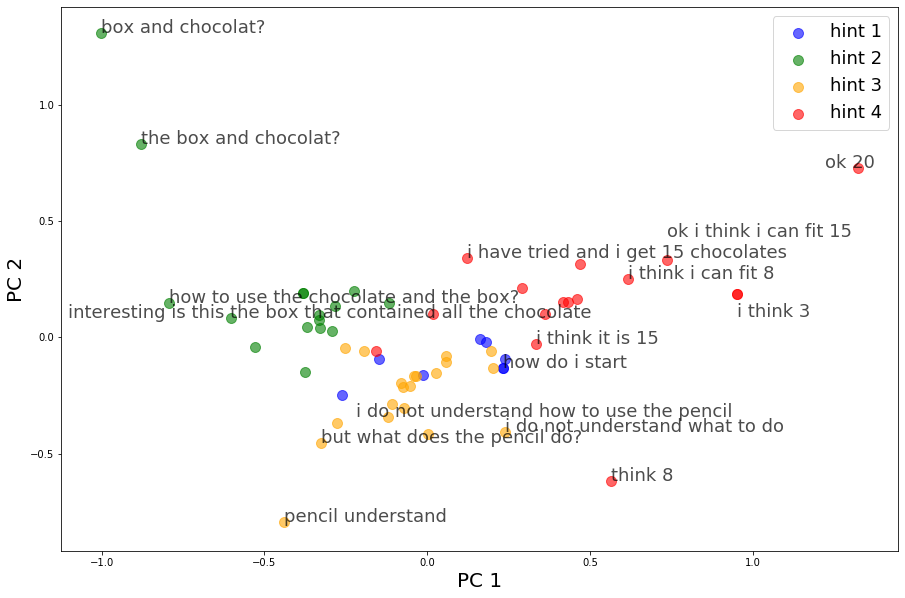

In [12]:
from sklearn.decomposition import PCA

# Visualization in 2 dimensions
pca = PCA(n_components=2).fit(vec)
vec2D = pca.transform(vec)
fig, ax = plt.subplots()
fig.set_figheight(10); fig.set_figwidth(15); 
colors = ['blue', 'green', 'orange', 'red', 'brown','purple', 'black', 'pink']
idx_with_annotation_original = [71, 47, 72, 5, 44, 32, 81, 20, 103, 6, 68, 1,7, 8, 11, 101, 104, 4, 69]
idx_with_annotation_simulated = [38, 26, 3, 28, 39, 40, 55, 9, 22, 24, 31, 48, 29, 15, 59, 16]
for h in np.unique(df.hint):
    idx = np.array(df.hint) == h
    ax.scatter(vec2D[idx,0], vec2D[idx,1], c=colors[h-1], label="hint "+str(h), s=100, alpha=0.6)
for i, txt in enumerate(range(nrows)):
    if OriginalData:
        if i in idx_with_annotation_original:
            x_shift = 0; y_shift = 0;
            if i == 68:
                y_shift = -0.05
            if i == 5:
                y_shift = -0.05
            elif i == 20:
                # protect shown name from private data
                ax.annotate("hi im joshua ok", (x_shift + vec2D[i,0], y_shift + vec2D[i,1]), size=18, alpha=0.7)
                continue
                ax.annotate(" ".join(df.words[i]), (x_shift + vec2D[i,0], y_shift + vec2D[i,1]), size=18, alpha=0.7)
                # ax.annotate(i, (vec2D[i,0], vec2D[i,1]), size=18, alpha=0.7)
    else:
        if i in idx_with_annotation_simulated:
            x_shift = 0; y_shift = 0;
            if i == 55:
                x_shift = -0; y_shift = 0.1
            elif i == 3:
                x_shift = -0.1
            elif i == 24:
                x_shift = -0.1
            elif i == 28:
                y_shift = -0.1
            elif i == 16:
                x_shift = -0.5
            ax.annotate(" ".join(df.words[i]), (x_shift + vec2D[i,0], y_shift + vec2D[i,1]), size=18, alpha=0.7)
ax.legend(fontsize=18)
ax.set_xlabel('PC 1', fontsize=20)
ax.set_ylabel('PC 2', fontsize=20)
fig.show()

When this runs for the simulated data, we see that the meanings of the sentences correlate almost perfectly with the given hints. This is not the  case for the real data, as the points are more mixed. Possible reasons being less data for each question and fewer words related to the confusion the children were experiencing.

# Models

Here we construct models and frameworks for evaluation and viusalization.

The model's performances are all evaluated using misclassification accuracy (accuracy) and mean absolute error (MAE)

## Utils

Here we define some utils used for the model fitting, selection and visualization.

In [13]:
# add previous hint as feature
def get_baseline(DF):
    counter = dict()
    baseline = []
    for index, row in DF.iterrows():
        n = row['Name']
        q = row['Question']
        if not (n,q) in counter:
            counter[(n,q)] = 1
        else:
            counter[(n,q)] += 1
        baseline.append(counter[(n,q)])
    return baseline

possible_hints = {
    # possible hints for each question
    1: [1,2,3,4],
    2: [1,2,3,4],
    3: [1,2,3,4],
    4: [1,2,3,4,5,6],
    5: [1,2,3,4,5,6,7,8],
    6: [1,2],
    }

def truncate(q, h, possible_hints):
    # truncates predicted hints into the valid interval
    min_hint = min(possible_hints[q])
    max_hint = max(possible_hints[q])
    if h < min_hint:
        h = min_hint
    elif h > max_hint: 
        h = max_hint
    return h

def vis_prediction(true_hint, predicted_hint, baseline, question, spec_question=None, extra_space=(0,0)):

    # input types
    true_hint = np.array(true_hint)
    predicted_hint = np.array(predicted_hint)
    question = np.array(question).astype(int)
    baseline = np.array(baseline).astype(int)
    questions = np.unique(question)

    if not spec_question is None:
        # if only want to look at one specific question
        q_idx = question == spec_question
        question = question[q_idx]
        true_hint = true_hint[q_idx]
        predicted_hint = predicted_hint[q_idx]
        baseline = baseline[q_idx]
        questions = np.array([spec_question])

    if len(questions) == 6:

        # If we're plotting all questions
        fig, (ax) = plt.subplots(len(questions)//2, 2, figsize=(22,16))

        # graphical parameters
        alpha_true = 0.5
        alpha_pred = 1
        alpha_base = 0.1
        s_true = 8
        s_pred = 7
        s_base = 7

        for i,q in enumerate(questions):
            row = i if i < len(questions)//2 else i - len(questions)//2
            col = int(i>=(len(questions)//2))
            idx = question == q
            b_i = baseline[idx]
            b_ind = np.where(b_i == 1)[0]
            for c in range(0,len(b_ind)):
                current = b_ind[c]
                if c == len(b_ind)-1:
                    next_kid = len(b_i)
                else:
                    next_kid = b_ind[c+1]

                x = np.arange(current,next_kid) if current != next_kid else current
                if c == 1:
                    ax[row][col].plot(x, true_hint[idx][x], '-o',
                                      label="true", markersize=s_true,
                                      alpha=alpha_true, linestyle='dashed',
                                      color='green')
                    ax[row][col].plot(x, predicted_hint[idx][x],
                                      '-*', label="predicted",markersize=s_pred, 
                                      linewidth=2, color='orange', alpha=alpha_pred)
                    ax[row][col].plot(x, baseline[idx][x],  '-s', label="baseline",
                                      markersize=s_base, alpha=alpha_base, color='blue',
                                      linestyle='dashed')
                else:
                    ax[row][col].plot(x, true_hint[idx][x], '-o',
                                      markersize=s_true, alpha=alpha_true, 
                                      linestyle='dashed', color='green')
                    ax[row][col].plot(x, predicted_hint[idx][x],  '-*',
                                      linewidth=2, color='orange',markersize=s_pred,
                                      alpha=alpha_pred)
                    ax[row][col].plot(x, baseline[idx][x], '-s',
                                      alpha=alpha_base, color='blue',
                                      markersize=s_base, linestyle='dashed')

        # limits
        ymin = 0-extra_space[0]; ymax = max(possible_hints[q])+1+extra_space[1]
        ax[row][col].set_ylim(ymin, ymax)

        # Show when new trajectory starts
        t = np.array(np.where(baseline[idx] == 1)[0])[1:] - 0.5
        ax[row][col].vlines(t, ymin, ymax, color="grey", alpha=0.4)

        # aesthetics
        ax[row][col].title.set_text('Question '+str(q))
        ax[row][col].legend(loc='center left', bbox_to_anchor=(1, 0.9))
        ax[row][col].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        ax[row][col].set_xlabel('timestep (each block corresponds to trajectory of given hints for one child)')
        ax[row][col].set_ylabel('hint')

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

    else:
        # If we're only looking at one quesion
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

        # graphical parameters
        alpha_true = 0.6
        alpha_pred = 1
        alpha_base = 0.5
        s_true = 25
        s_pred = 18
        s_base = 15
        lw_base = 9 # linewidth
        lw_true = 5
        lw_pred = 3

        b_i = baseline
        b_ind = np.where(b_i == 1)[0]
        for c in range(0,len(b_ind)):
            current = b_ind[c]
            if c == len(b_ind)-1:
                next_kid = len(b_i)
            else:
                next_kid = b_ind[c+1]

            x = np.arange(current,next_kid) if current != next_kid else current
            if c == 1:
                ax.plot(x, baseline[x],  '-s', label="baseline", markersize=s_base,
                        alpha=alpha_base, linewidth=lw_base, color='blue') #, linestyle='dashed')
                ax.plot(x, true_hint[x], '-o', label="true", markersize=s_true,
                        alpha=alpha_true, linestyle='dashed',linewidth=lw_true, color='green')
                ax.plot(x, predicted_hint[x],  '-*', label="predicted",markersize=s_pred,
                        linewidth=lw_pred, color='orange', alpha=alpha_pred)#, linestyle='dashed')
            else:
                ax.plot(x, baseline[x], '-s',  alpha=alpha_base, linewidth=lw_base,
                        color='blue', markersize=s_base) #, linestyle='dashed')
                ax.plot(x, true_hint[x], '-o', markersize=s_true, alpha=alpha_true, 
                        linestyle='dashed',linewidth=lw_true, color='green')
                ax.plot(x, predicted_hint[x],  '-*', linewidth=lw_pred, color='orange',
                        markersize=s_pred, alpha=alpha_pred)#, linestyle='dashed')

        # limits
        ymin = 0-extra_space[0]; ymax = max(possible_hints[questions[0]])+1++extra_space[1]
        ax.set_ylim(ymin, ymax)

        # Show when new trajectory starts
        t = np.array(np.where(baseline == 1)[0])[1:] - 0.5
        ax.vlines(t, ymin, ymax, color="grey", alpha=0.4)

        # aesthetics
        # ax.title.set_text('Question 2')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.88), fontsize=30)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', labelsize=30)

        ax.set_xlabel('Timestep',fontsize=30)
        ax.set_ylabel('Hint', fontsize=30)
    
    return fig

#Leave_one_out_CV
def LOO_split(X, names):
    diff_names = names.unique()
    splits = list()
    
    for name in diff_names:
        traini = names != name
        testi = names == name
        splits.append([list(traini), list(testi)])
    return splits

## Baseline

The baseline is just to predict hints in increasing order starting with hint number 1 for each subquestion: 1,2,3,4.

Here the baseline performance is evaluated.

In [14]:
X = df.drop('hint', axis= 1)
y = df.hint.astype('float')

### Only predicting the most frequent hint ###
hint_count = np.unique(y,return_counts=True)
highest_freq = np.max(hint_count[1])
most_freq_hint = hint_count[0][np.argmax(hint_count[1])]
print("Only predicting hint number", most_freq_hint, 
      "would give LOOCV classification of", round(highest_freq/len(np.array(y)),4), "%")

### Baseline ###
baseline = get_baseline(df)
print("Baseline guesses that are 1: ", np.mean(baseline == np.array([1]*len(baseline))))
print("Baseline classification accuracy: ", np.mean(baseline == np.array(df.hint)))
print("Baseline MAE: ", np.mean(abs(np.subtract(baseline, np.array(df.hint)))))

Only predicting hint number 3.0 would give LOOCV classification of 0.3333 %
Baseline guesses that are 1:  0.3333333333333333
Baseline classification accuracy:  0.4
Baseline MAE:  0.8


## Feature Selection

Here we construct multiple choices for the statespace representation. They all build on top of each other, starting with the current sub-question and previous hint given (**X_QH**). You can then add selected features (features that turned out to have some correlation with the response) from the meta data (**X_selected_features**). Finally you can decide to add the BOW-representation to the set of featurs (**X_BOW**) or W2V-representation in p_WV dimensions (**X_WV**)

In [15]:
# Data for models

# response
y = df.hint

# question one-hot-encoding
qohe = pd.DataFrame(pd.get_dummies(df['Question'], prefix="Q"))

# hint one-ho-encoding
hohe = pd.DataFrame(pd.get_dummies(df['prev_hint'], prefix="P_H"))

# selected meta features 
selected_features = df[['prev_hint', 'Total Pre', 'nWords']] 

# Word-2-Vec
WV_features_raw = pd.DataFrame(vec) # raw 300D vector space
WV_features = pca_reduction(vec, p_WV=4) # pca reduction

# Select variables X
X_QH = pd.concat([qohe, df['prev_hint']], axis=1).reindex(qohe.index) # only Q's and previous hints
X_selected_features = pd.concat([qohe, selected_features], axis=1).reindex(qohe.index) # selected Meta features
X_BOW = pd.concat([qohe, selected_features, BOW_features], axis=1).reindex(qohe.index) # BOW data
X_WV = pd.concat([qohe, selected_features, WV_features], axis=1).reindex(qohe.index) # W2V data

X = X_WV

## Model fitting

### Linear Regression

LOO average classification: 0.5
LOO MAE: 0.5333333333333333


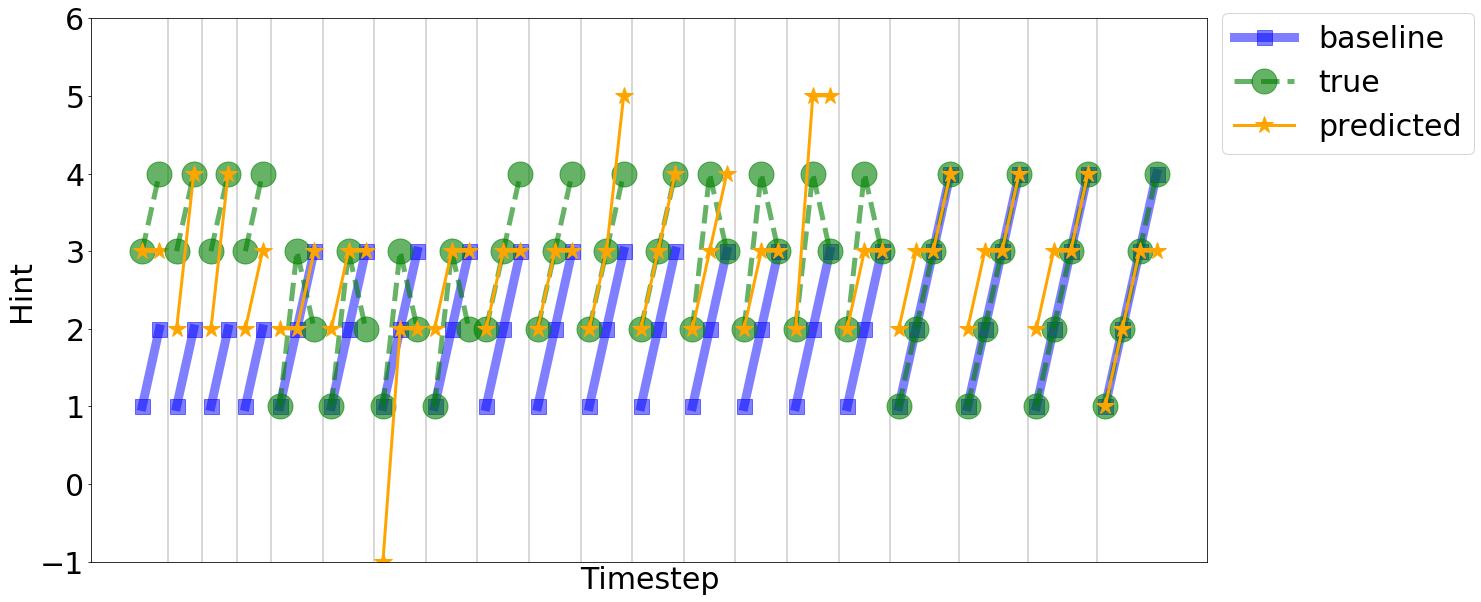

In [16]:
# import models ...
from sklearn.linear_model import LinearRegression

def evaluate(clf, X, y, df, vis_spec_question=None, vis_extra_space=(0,0)):
    """
    Function to evaluate a given classifier, and a dataset X ~ y. 
    df is for analysis e.g. baseline accuracy

    Possible models:
    "Linear Regression"
    wanted to include all models but took too much time..
    """
    baseline = np.array(get_baseline(df))
    question = np.array(df['Question'])
    y_hat_vec = []; y_test_vec = []; b_vec = []; q_vec = [];

    for train_index, test_index in LOO_split(X, df['Name']):
        # train, test split
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        # gather data on question and baseline for analysis
        b_vec += list(baseline[test_index])
        q_vec += list(question[test_index])

        # fit and predict
        clf = LinearRegression()
        clf.fit(X_train, y_train)
        y_hat = []
        if X_test.shape[0] != 1: # if length is 1 we will not need a for loop
            for i in range((X_test.shape[0])-1):
                testrow = X_test.iloc[i,:].values.reshape(1,-1)
                y_hat.append(np.round(clf.predict(testrow))[0])
                if X_test['prev_hint'].iat[i+1] != 0: #reset to prev_hint = 0 for new subquestion
                    X_test['prev_hint'].iat[i+1] = y_hat[-1] #otherwise change the prev_hint in our actually generated hint
            testrow = X_test.iloc[X_test.shape[0]-1,:].values.reshape(1,-1) #do last one outside loop (otherwise if statement has out of index)
            y_hat.append(np.round(clf.predict(testrow))[0])
        else:
            y_hat.append(np.round(clf.predict(X_test))[0])

        # store predictions and true value
        y_hat_vec += list(y_hat)
        y_test_vec += list(y_test)

    mis_class_acc = np.mean(np.array(y_test_vec)==np.array(y_hat_vec))
    MAE = np.mean(abs(np.array(y_test_vec)-np.array(y_hat_vec)))

    print('LOO average classification: {}'.format(mis_class_acc))
    print('LOO MAE: {}'.format(MAE))

    vis_pred = vis_prediction(y_test_vec, y_hat_vec, baseline=b_vec, 
                              question=q_vec, spec_question = vis_spec_question, 
                              extra_space= vis_extra_space)

    return mis_class_acc, MAE, vis_pred

acc, err, fig = evaluate(clf="Linear Regression", X=X, y=y, df=df, vis_spec_question=None, vis_extra_space=(1,1))

### Lasso

LOO average classification: 0.48333333333333334
LOO MAE: 0.5166666666666667
non_zero_variables: {'WV_0', 'WV_1', 'WV_2', 'Total Pre', 'nWords', 'prev_hint'}
non_zero_words: []


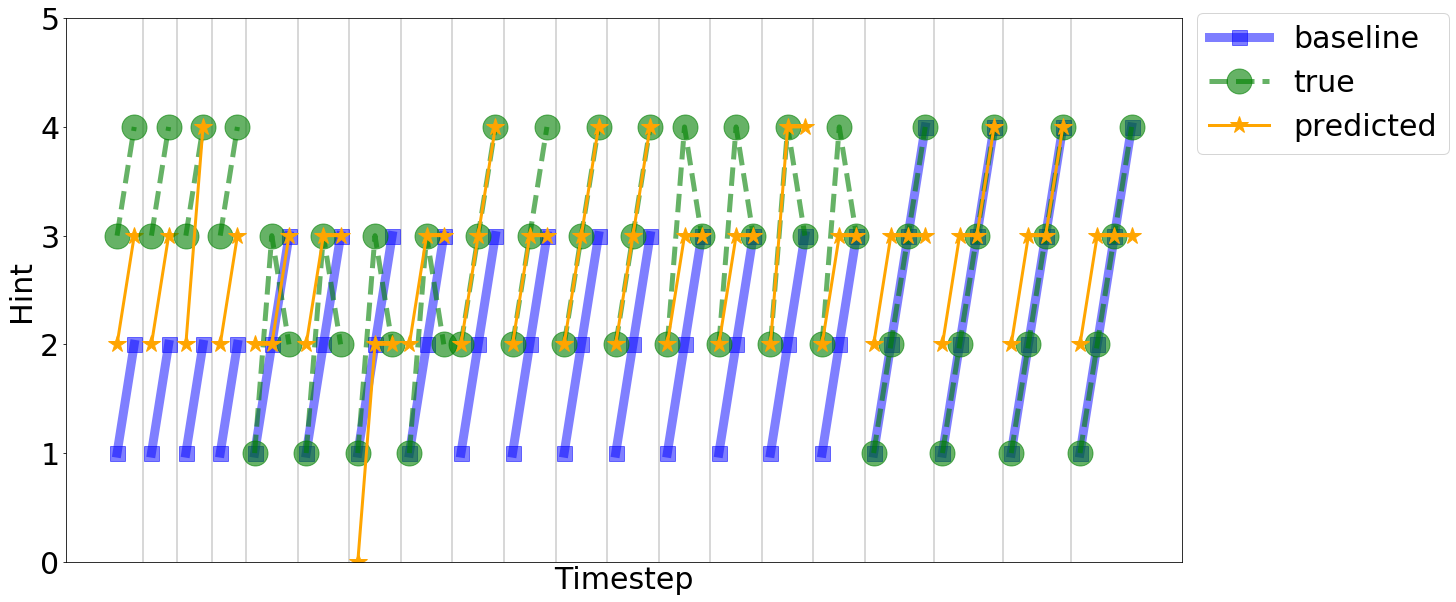

In [17]:
pd.set_option('display.max_rows', None)
from sklearn import linear_model
from sklearn.linear_model import LassoCV

# set training data
# X = X_selected_features

baseline = np.array(get_baseline(df))
question = np.array(df['Question'])
y_hat_vec = []; y_test_vec = []; b_vec = []; q_vec = [];
non_zero_variables = set() # non-zero ceoffs
# counter = 0
for train_index, test_index in LOO_split(X, df['Name']):
    # train, test split
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # choice of alpha (lambda..)
    a = LassoCV(cv=17, random_state=0).fit(X_train,y_train).alpha_

    # # Here you can choice the set of features before predicting
    Lasso_subset = linear_model.Lasso(alpha=a)
    Lasso_subset.fit(X_train, y_train)
    coeffs = abs(Lasso_subset.coef_)
    zipped = list(zip(coeffs, X_train.columns))
    res = sorted(zipped, key = lambda x: x[0], reverse=True) 
    for r in res[:30]:
        if r[0] > 0:
            non_zero_variables.add(r[1])

    # gather data on question and baseline for analysis
    b_vec += list(baseline[test_index])
    q_vec += list(question[test_index])

    # fit and predict
    Lasso = linear_model.Lasso(alpha=a) # alpha = 0.01)
    Lasso.fit(X_train, y_train)
    y_hat = []
    if X_test.shape[0] != 1: # if length is 1 we will not need a for loop
        for i in range((X_test.shape[0])-1):
            testrow = X_test.iloc[i,:].values.reshape(1,-1)
            y_hat.append(np.round(Lasso.predict(testrow))[0])
            if X_test['prev_hint'].iat[i+1] != 0: #reset to prev_hint = 0 for new subquestion
                X_test['prev_hint'].iat[i+1] = y_hat[-1] #otherwise change the prev_hint in our actually generated hint
    
        testrow = X_test.iloc[X_test.shape[0]-1,:].values.reshape(1,-1) #do last one outside loop (otherwise if statement has out of index)
        y_hat.append(np.round(Lasso.predict(testrow))[0])
    else:
        y_hat.append(np.round(Lasso.predict(X_test))[0])
 
    # store predictions and true value
    y_hat_vec += list(y_hat)
    y_test_vec += list(y_test)

mis_class_acc = np.mean(np.array(y_test_vec)==np.array(y_hat_vec))
MAE_acc = np.mean(abs(np.array(y_test_vec)-np.array(y_hat_vec)))

print('LOO average classification: {}'.format(mis_class_acc))
print('LOO MAE: {}'.format(MAE_acc))

vis_pred = vis_prediction(y_test_vec, y_hat_vec, baseline=b_vec, question=q_vec)

print("non_zero_variables:", non_zero_variables)
non_zero_variables = np.array(list(non_zero_variables))
non_zero_words = list(non_zero_variables[np.where([s[0:2]=="w_" for s in non_zero_variables])[0]])
non_zero_words
print("non_zero_words:", non_zero_words)

### Logistic Regression

LOO average classification: 0.8666666666666667
LOO MAE: 0.2


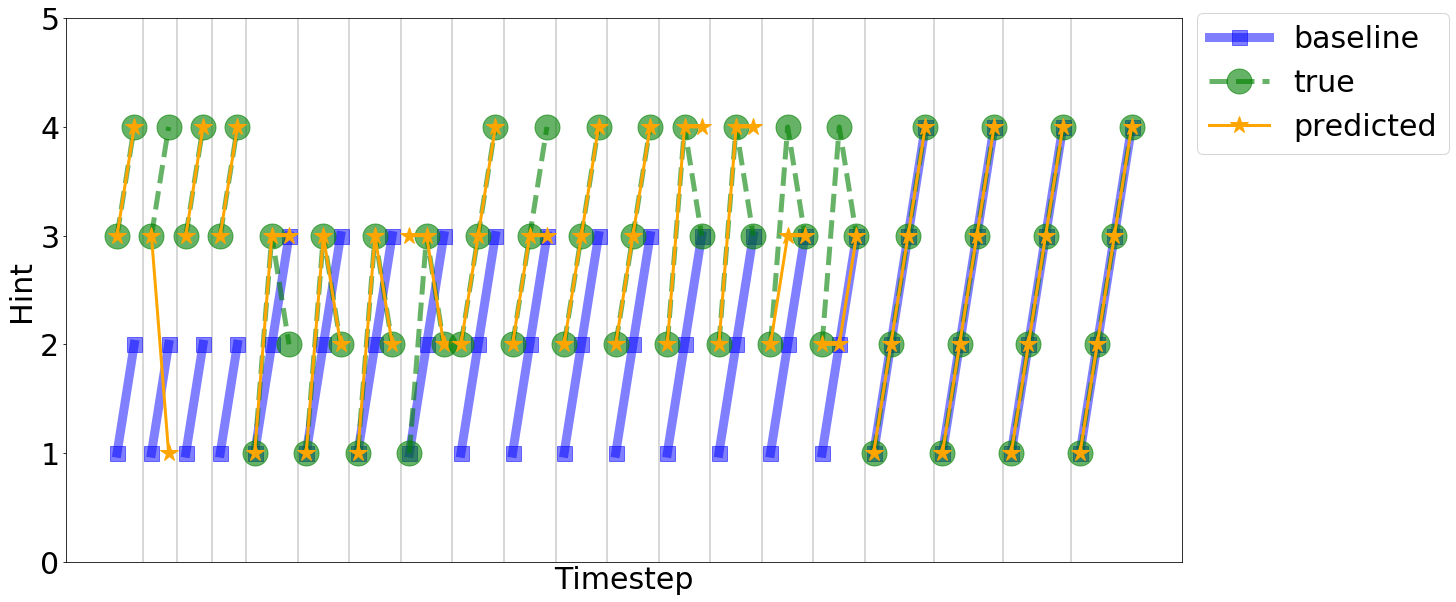

In [18]:
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

y = np.array(df.hint.astype('category'))

# modeling
y_hat_vec = []; y_test_vec = []; b_vec = []; q_vec = [];
baseline = np.array(get_baseline(df))
question = np.array(df['Question'])

# non-zero ceoffs
non_zero_variables = set()
# counter = 0
for train_index, test_index in LOO_split(X, df['Name']):
    # train, test split
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # gather data on question and baseline for analysis
    b_vec += list(baseline[test_index])
    q_vec += list(question[test_index])

    # choice of alpha (lambda..)
    cs = [10**i for i in [-1,0,1,2,3]]
    cv_acc = []
    for c in cs:
        cv_clf = LogisticRegression(random_state=0, penalty="l1", C=c, solver='saga',max_iter=100000)
        # cv_clf = LogisticRegression(random_state=0, penalty="l2", C=c, max_iter=100000)
        scores = cross_val_score(cv_clf, X_train, y_train, cv=5)
        cv_acc.append(np.mean(scores))
    c = cs[np.argmax(cv_acc)]
  
    # fit and predict
    LogReg = LogisticRegression(random_state=0, penalty="l1", C=c, solver='saga',max_iter=100000).fit(X_train, y_train)
    # LogReg = LogisticRegression(random_state=0, penalty="l2", C=c, max_iter=100000).fit(X_train, y_train)
    # LogReg = LogisticRegression(random_state=0, penalty="none", max_iter=100000).fit(X_train, y_train)

    y_hat = []
    if X_test.shape[0] != 1: # if length is 1 we will not need a for loop
        for i in range((X_test.shape[0])-1):
            testrow = X_test.iloc[i,:].values.reshape(1,-1)
            y_hat.append(np.round(LogReg.predict(testrow))[0])
            if X_test['prev_hint'].iat[i+1] != 0: # reset to prev_hint = 0 for new subquestion
                X_test['prev_hint'].iat[i+1] = y_hat[-1] # otherwise change the prev_hint in our actually generated hint
                
        testrow = X_test.iloc[X_test.shape[0]-1,:].values.reshape(1,-1) #do last one outside loop (otherwise if statement has out of index)
        y_hat.append(np.round(LogReg.predict(testrow))[0])
    else:
        y_hat.append(np.round(LogReg.predict(X_test))[0])

    # store predictions and true value
    y_hat_vec += list(y_hat)
    y_test_vec += list(y_test)
    
mis_class_acc = np.mean(np.array(y_test_vec)==np.array(y_hat_vec))
MAE_acc = np.mean(abs(np.array(y_test_vec)-np.array(y_hat_vec)))

print('LOO average classification: {}'.format(mis_class_acc))
print('LOO MAE: {}'.format(MAE_acc))

vis_pred = vis_prediction(y_test_vec, y_hat_vec, baseline=b_vec, question=q_vec)

### Random Forest

LOO average classification: 0.9333333333333333
LOO MAE: 0.11666666666666667


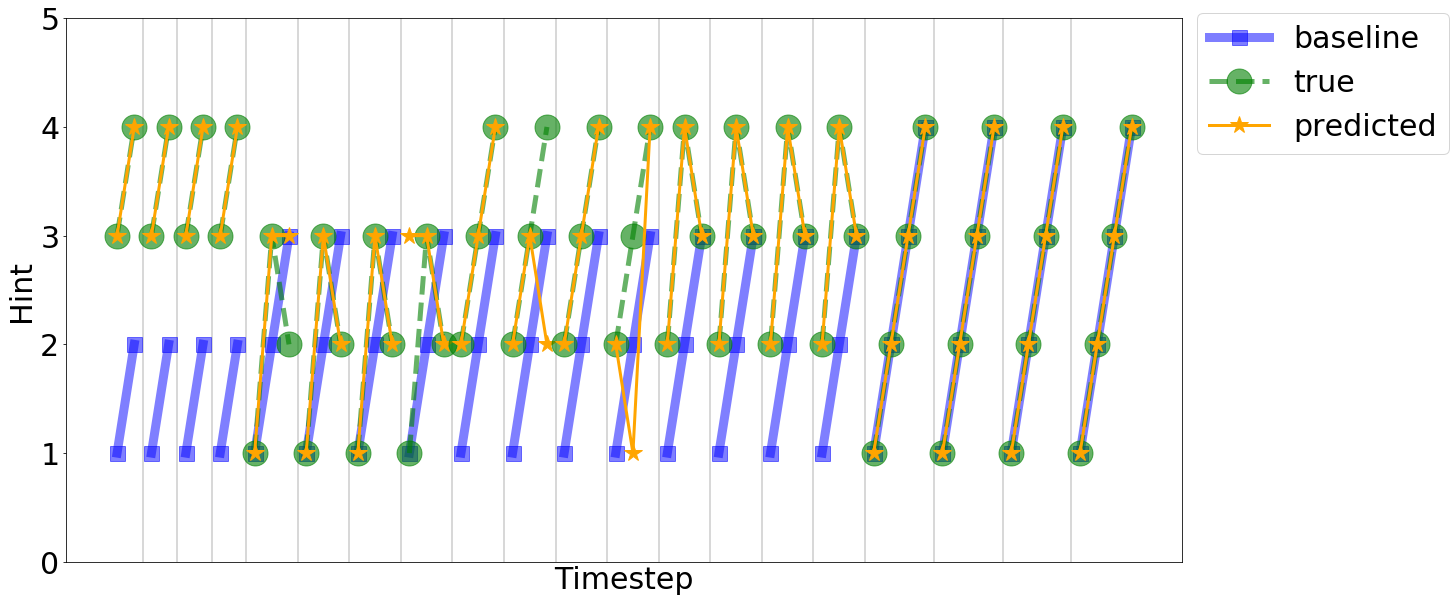

In [19]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

y = np.array(df.hint.astype('category'))

# modeling
y_hat_vec = []; y_test_vec = []; b_vec = []; q_vec = [];
baseline = np.array(get_baseline(df))
question = np.array(df['Question'])

feature_imp = []
for train_index, test_index in LOO_split(X, df['Name']):
    # train, test split
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # gather data on question and baseline for analysis
    b_vec += list(baseline[test_index])
    q_vec += list(question[test_index])

    # choice of n_estimators
    ns = [10,20,30,40,50,60, 70,80]
    cv_acc = []
    for n_ in ns:
        cv_clf = RandomForestClassifier(n_estimators=n_, random_state=0, max_depth=500)
        scores = cross_val_score(cv_clf, X_train, y_train, cv=5)
        cv_acc.append(float(np.mean(scores)))
  
    max_idx = np.argmax(cv_acc) # np.where(np.array(cv_acc)==max(cv_acc))[0][0]
    n = ns[max_idx]
    RF = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=500)
    RF.fit(X_train, y_train)
    feature_imp.append(RF.feature_importances_)

    y_hat = []
    if X_test.shape[0] != 1: # if length is 1 we will not need a for loop
        for i in range((X_test.shape[0])-1):
            testrow = X_test.iloc[i,:].values.reshape(1,-1)
            y_hat.append(np.round(RF.predict(testrow))[0])
            if X_test['prev_hint'].iat[i+1] != 0: # reset to prev_hint = 0 for new subquestion
                X_test['prev_hint'].iat[i+1] = y_hat[-1] # otherwise change the prev_hint in our actually generated hint
    
        testrow = X_test.iloc[X_test.shape[0]-1,:].values.reshape(1,-1) #do last one outside loop (otherwise if statement has out of index)
        y_hat.append(np.round(RF.predict(testrow))[0])
    else:
        y_hat.append(np.round(RF.predict(X_test))[0])
 
    # store predictions and true value
    y_hat_vec += list(y_hat)
    y_test_vec += list(y_test)

mis_class_acc = np.mean(np.array(y_test_vec)==np.array(y_hat_vec))
MAE_acc = np.mean(abs(np.array(y_test_vec)-np.array(y_hat_vec)))

print('LOO average classification: {}'.format(mis_class_acc))
print('LOO MAE: {}'.format(MAE_acc))

vis_pred = vis_prediction(y_test_vec, y_hat_vec, baseline=b_vec, question=q_vec)

### Ensemble

LOO average misclassification: 0.48333333333333334
LOO MAE: 0.5166666666666667


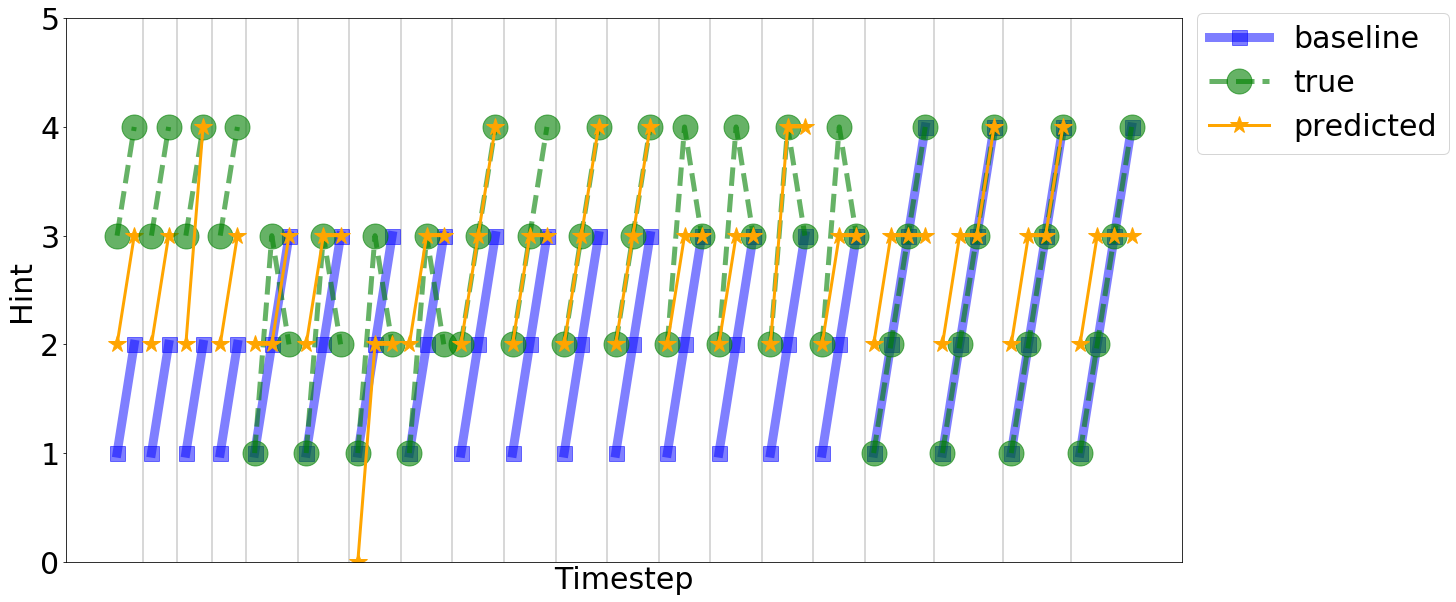

In [20]:
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import operator

y = df.hint

method = "vote"
# method = "average"

# modeling
y_hat_vec = []; y_test_vec = []; b_vec = []; q_vec = [];
baseline = np.array(get_baseline(df))
question = np.array(df['Question'])

# don't go lower then linear predictor
def adjust(pred, linear_pred):
    if pred > linear_pred:
        return pred
    else:
        return linear_pred

def vote(v):
    # print("v:", v)
    values = set(v)
    if len(v) == len(values):
        return np.round(np.median(v))

    D = dict()
    for s in values:
        D[s] = 0

    for s in v:
        D[s] += 1

    sorted_votes = sorted(D.items(), key=operator.itemgetter(1), reverse=True)

    return sorted_votes[0][0]

def get_enemble_pred(votes, method):
    if method == "average":
        pred = np.round(np.mean(votes))
    elif method == "vote":
        pred = np.round(np.mean(vote(votes)))
    return pred


# non-zero ceoffs
non_zero_variables = set()
# counter = 0
for train_index, test_index in LOO_split(X, df['Name']):
    # train, test split
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # -------------------- Lasso --------------------
    # choice of alpha (lambda..)
    a = LassoCV(cv=17, random_state=0).fit(X_train,y_train).alpha_

    # # Here you can choice the set of features before predicting
    Lasso_subset = linear_model.Lasso(alpha=a)
    Lasso_subset.fit(X_train, y_train)
    coeffs = abs(Lasso.coef_)
    zipped = list(zip(coeffs, X_train.columns))
    res = sorted(zipped, key = lambda x: x[0], reverse=True) 
    for r in res[:30]:
        if r[0] > 0:
            non_zero_variables.add(r[1])

    # gather data on question and baseline for analysis
    b_vec += list(baseline[test_index])
    q_vec += list(question[test_index])

    # fit and predict
    Lasso = linear_model.Lasso(alpha=a) # alpha = 0.01)
    Lasso.fit(X_train, y_train)

    # # ---------------- Logistic L1 ----------------
    # # choice of alpha (lambda..)
    # cs = [10**i for i in [-1,0,1,2,3]]
    # cv_acc = []
    # for c in cs:
    #   cv_clf = LogisticRegression(random_state=0, penalty="l1", C=c, solver='saga',max_iter=100000)
    #   scores = cross_val_score(cv_clf, X_train, y_train.astype('category'), cv=5)
    #   cv_acc.append(np.mean(scores))
    # c = cs[np.argmax(cv_acc)]

    # # fit and predict
    # LogReg = LogisticRegression(random_state=0, penalty="l1", C=c, solver='saga',max_iter=100000)
    # LogReg.fit(X_train, y_train.astype('category'))
    
    # ------------- Linear Regression -------------

    # fit and predict
    LinReg = LinearRegression()
    LinReg.fit(X_train, y_train)

    # ---------------- Random Forest ----------------

    # choice of n_estimators
    ns = [10,20,30,40,50,60, 70,80]
    cv_acc = []
    for n in ns:
        cv_clf = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=500)
        scores = cross_val_score(cv_clf, X_train, y_train.astype('category'), cv=5)
        cv_acc.append(np.mean(scores))
    n = ns[np.argmax(cv_acc)]
    RF = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=500)
    RF.fit(X_train, y_train.astype('category'))

    y_hat = []
    if X_test.shape[0] != 1: # if length is 1 we will not need a for loop
        for i in range((X_test.shape[0])-1):
            testrow = X_test.iloc[i,:].values.reshape(1,-1)
            Lass_pred = np.round(Lasso.predict(testrow))[0]
            LinReg_pred = np.round(Lasso.predict(testrow))[0]
            # Logi_pred = adjust(np.round(LogReg.predict(testrow))[0], Lass_pred)
            RF_pred =  adjust(np.round(RF.predict(testrow))[0], Lass_pred)
            ensample_pred = get_enemble_pred([Lass_pred, 
                                            # Logi_pred, 
                                            RF_pred, 
                                            LinReg_pred], method=method)
            y_hat.append(ensample_pred)
            if X_test['prev_hint'].iat[i+1] != 0: #reset to prev_hint = 0 for new subquestion
                X_test['prev_hint'].iat[i+1] = y_hat[-1] #otherwise change the prev_hint in our actually generated hint
        
        testrow = X_test.iloc[X_test.shape[0]-1,:].values.reshape(1,-1) #do last one outside loop (otherwise if statement has out of index)
        LinReg_pred = np.round(Lasso.predict(testrow))[0]
        Lass_pred = np.round(Lasso.predict(testrow))[0]
        # Logi_pred = adjust(np.round(LogReg.predict(testrow))[0], Lass_pred)
        RF_pred =  adjust(np.round(RF.predict(testrow))[0], Lass_pred)
        ensample_pred = get_enemble_pred([Lass_pred, 
                                          # Logi_pred, 
                                          RF_pred, 
                                          LinReg_pred], method=method)
        y_hat.append(ensample_pred)
    else:
        LinReg_pred = np.round(Lasso.predict(X_test))[0]
        Lass_pred = np.round(Lasso.predict(X_test))[0]
        # Logi_pred = adjust(np.round(LogReg.predict(X_test))[0], Lass_pred)
        RF_pred = adjust(np.round(RF.predict(X_test))[0], Lass_pred)
        ensample_pred = get_enemble_pred([Lass_pred, 
                                          # Logi_pred, 
                                          RF_pred, LinReg_pred], method=method)
        y_hat.append(ensample_pred)
 
    # store predictions and true value
    y_hat_vec += list(y_hat)
    y_test_vec += list(y_test)
    
mis_class_acc = np.mean(np.array(y_test_vec)==np.array(y_hat_vec))
MAE_acc = np.mean(abs(np.array(y_test_vec)-np.array(y_hat_vec)))

print('LOO average misclassification: {}'.format(mis_class_acc))
print('LOO MAE: {}'.format(MAE_acc))

vis_pred = vis_prediction(y_test_vec, y_hat_vec, baseline=b_vec, question=q_vec)


## Comparing models

After manually trying combinations of features and models, we can compare the performance visually. These plots are used in our paper.

### Accuracy for original data

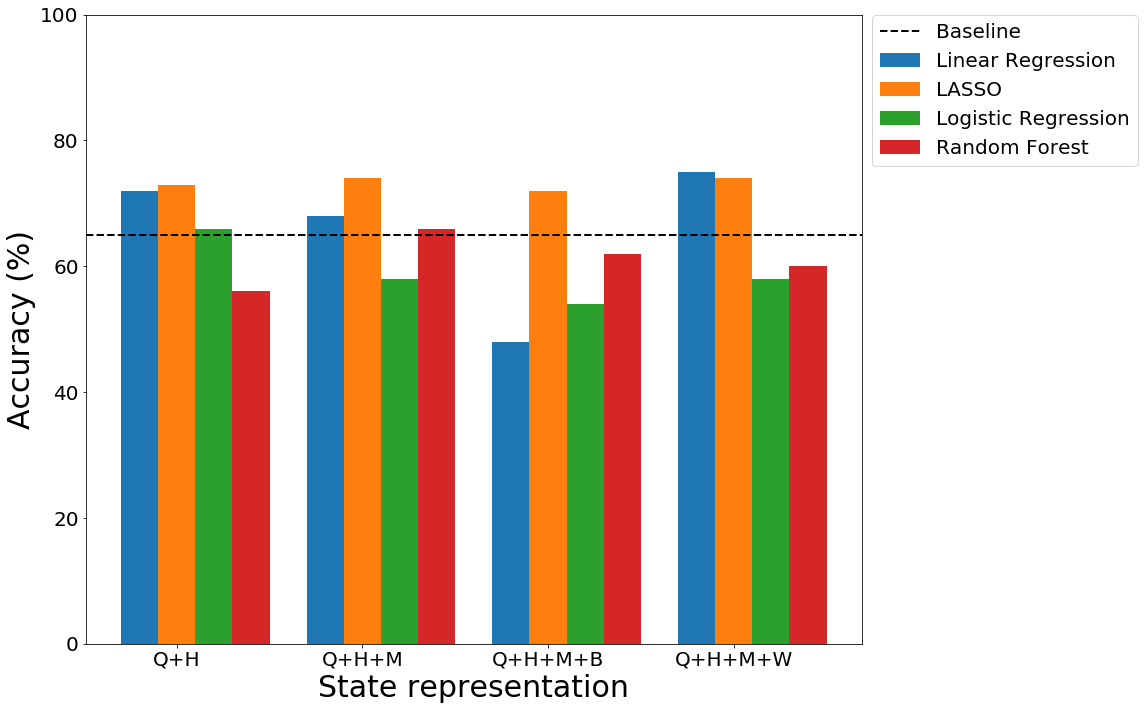

In [21]:
# Accuracy
labels = ['Q+H',
          'Q+H+M', 
          'Q+H+M+B', 
          'Q+H+M+W']
LinReg_acc = [72, 68, 48, 75]
LASSO_acc =  [73, 74, 72, 74]
LogReg_acc = [66, 58, 54, 58]
RF_acc =     [56, 66, 62, 60]
baseline_acc = 65

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,10))
rects1 = ax.bar(x - 1*width, LinReg_acc, width, label='Linear Regression', alpha=1)
rects2 = ax.bar(x, LASSO_acc, width, label='LASSO' , alpha=1)
rects3 = ax.bar(x+width, LogReg_acc, width, label='Logistic Regression', alpha=1)
rects4 = ax.bar(x + 2*width, RF_acc, width, label='Random Forest', alpha=1)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=30)
ax.set_xlabel('State representation', fontsize=30)
# ax.set_title('Model accuracy for different state space representations')
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(labels,  fontsize=20)
ax.set_ylim(0,100)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 4, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.axhline(y=baseline_acc, linewidth=2,  linestyle="dashed",  color='black', label="Baseline")
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.88))

fig.tight_layout()

plt.show()

### MAE for original data

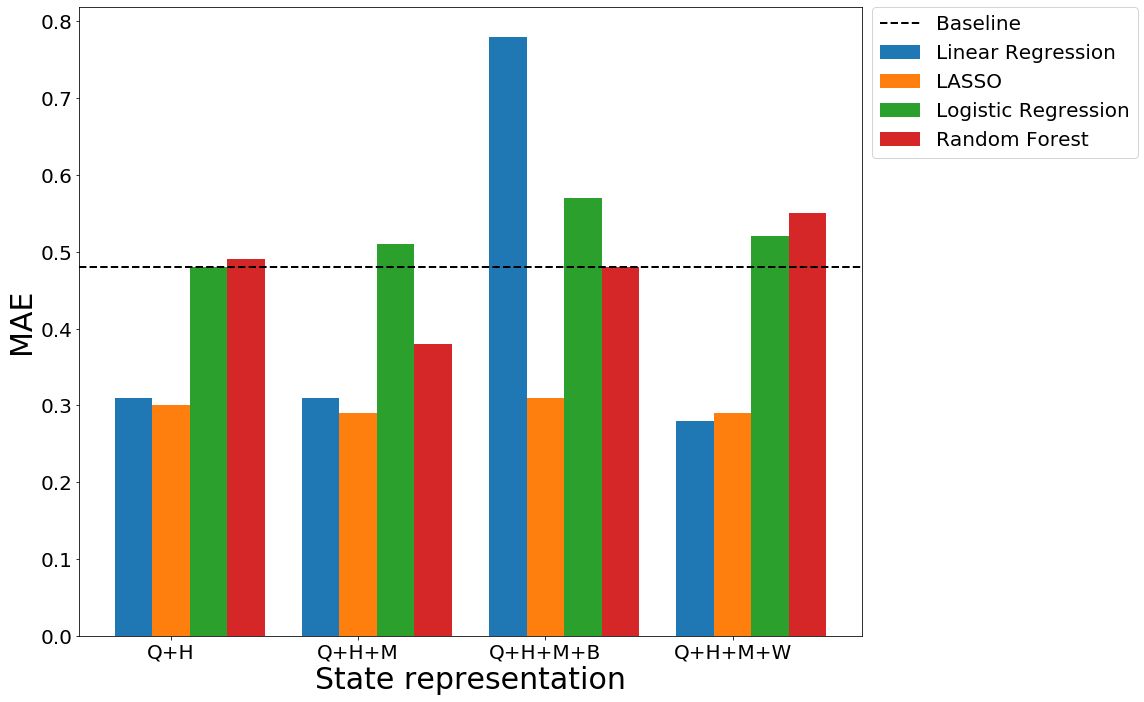

In [22]:
# MAE
labels = ['Q+H', 'Q+H+M', 'Q+H+M+B', 'Q+H+M+W']
LinReg_mae = [0.31, 0.31, 0.78, 0.28]
LASSO_mae =  [0.30, 0.29, 0.31, 0.29]
LogReg_mae = [0.48, 0.51, 0.57, 0.52]
RF_mae =     [0.49, 0.38, 0.48, 0.55]
baseline_mae = 0.48

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,10))
rects1 = ax.bar(x - 1*width, LinReg_mae, width, label='Linear Regression')
rects2 = ax.bar(x, LASSO_mae, width, label='LASSO')
rects3 = ax.bar(x+width, LogReg_mae, width, label='Logistic Regression')
rects4 = ax.bar(x + 2*width, RF_mae, width, label='Random Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE', fontsize=30)
# ax.set_title('Model accuracy for different state space representations')
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(labels,  fontsize=20)
ax.set_xlabel('State representation', fontsize=30)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 4, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.axhline(y=baseline_mae, linewidth=2,  linestyle="dashed",  color='black', label="Baseline")
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.88))

fig.tight_layout()

plt.show()

### Accuracy for simulated data

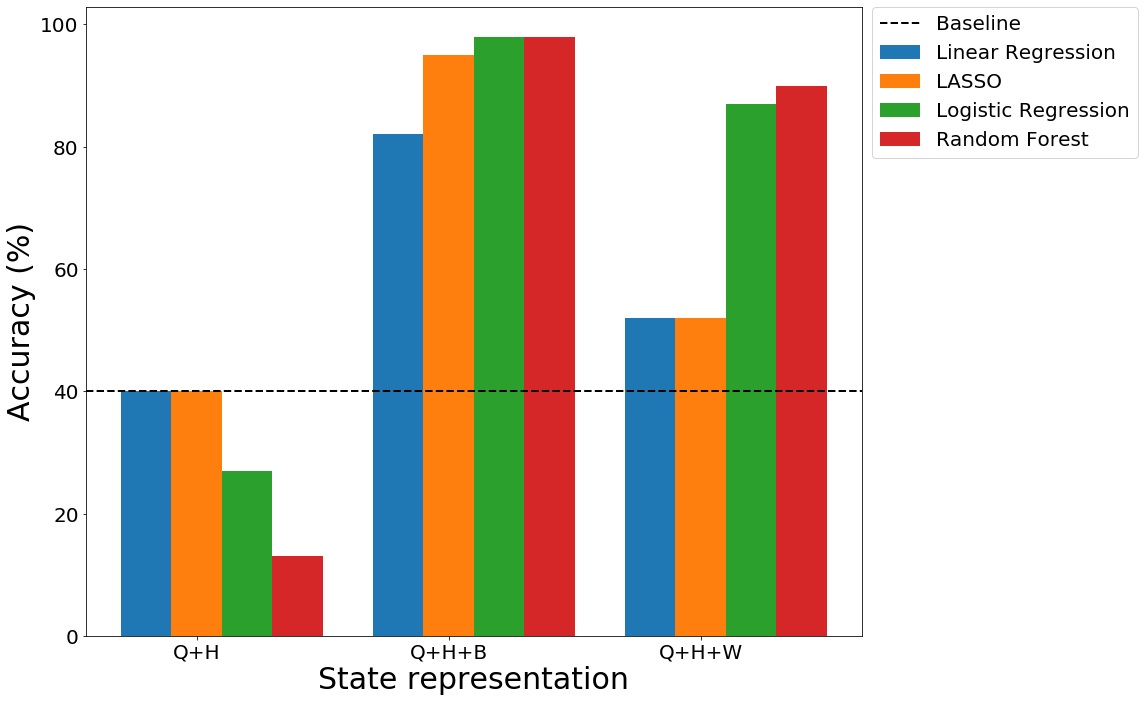

In [23]:
# Accuracy
labels = ['Q+H',
          'Q+H+B', 
          'Q+H+W']
LinReg_acc = [40, 82, 52]
LASSO_acc =  [40, 95, 52]
LogReg_acc = [27, 98, 87]
RF_acc =     [13, 98, 90]
baseline_acc = 40

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,10))
rects1 = ax.bar(x - 1*width, LinReg_acc, width, label='Linear Regression', alpha=1)
rects2 = ax.bar(x, LASSO_acc, width, label='LASSO' , alpha=1)
rects3 = ax.bar(x+width, LogReg_acc, width, label='Logistic Regression', alpha=1)
rects4 = ax.bar(x + 2*width, RF_acc, width, label='Random Forest', alpha=1)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=30)
# ax.set_title('Model accuracy for different state space representations')
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(labels,  fontsize=20)
ax.set_xlabel('State representation', fontsize=30)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 4, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.axhline(y=baseline_acc, linewidth=2,  linestyle="dashed",  color='black', label="Baseline")
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.88))


fig.tight_layout()

plt.show()

### MAE for simulated data

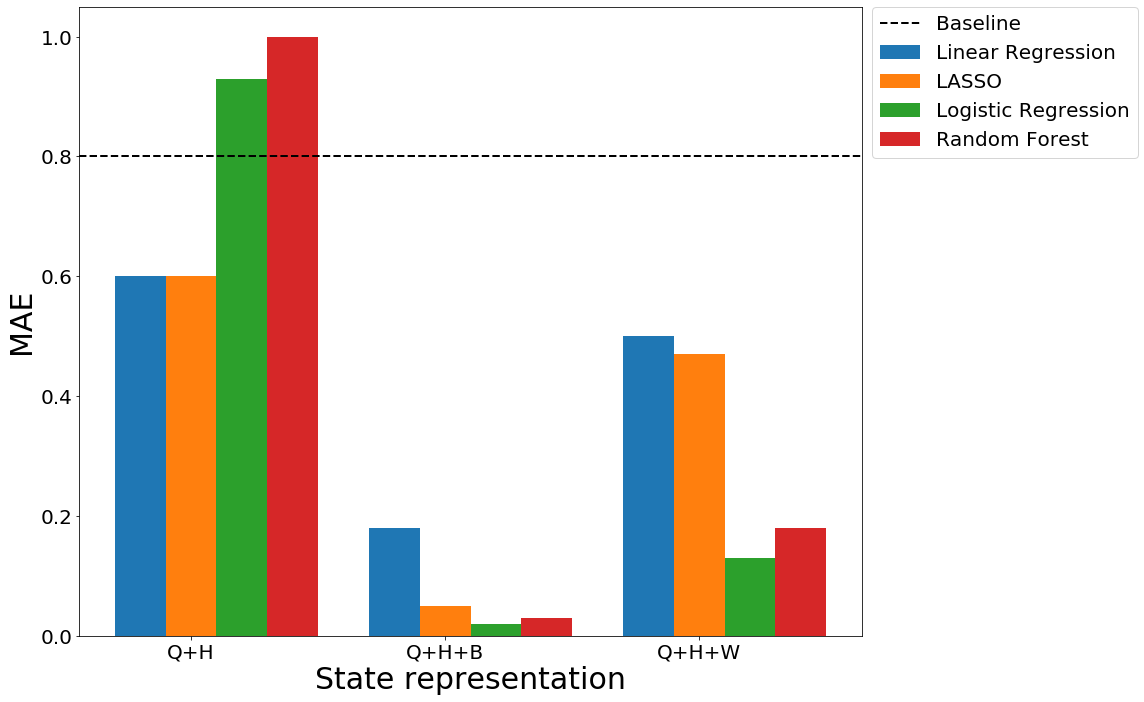

In [24]:
# MAE
labels = ['Q+H', 'Q+H+B', 'Q+H+W']
LinReg_mae = [0.6, 0.18, 0.5]
LASSO_mae =  [0.6, 0.05, 0.47]
LogReg_mae = [0.93, 0.02, 0.13]
RF_mae =     [1, 0.03, 0.18]
baseline_mae = 0.8

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(16,10))
rects1 = ax.bar(x - 1*width, LinReg_mae, width, label='Linear Regression')
rects2 = ax.bar(x, LASSO_mae, width, label='LASSO')
rects3 = ax.bar(x+width, LogReg_mae, width, label='Logistic Regression')
rects4 = ax.bar(x + 2*width, RF_mae, width, label='Random Forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE', fontsize=30)
# ax.set_title('Model accuracy for different state space representations')
ax.set_xticks(x)
ax.tick_params(labelsize=20)
ax.set_xticklabels(labels,  fontsize=20)
ax.set_xlabel('State representation', fontsize=30)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 4, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.axhline(y=baseline_mae, linewidth=2,  linestyle="dashed",  color='black', label="Baseline")
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.88))

fig.tight_layout()

plt.show()

## Feature importance

Some extra information on feature importance in the Random Forest model for the Q+H+M+W features. Even though it is not in the paper, it is stil interesting. The following are the parameters in sorted order. w_XYZ means XYZ is a word encoded in the BOW representation.

In [26]:
f = np.array(feature_imp)
fi = np.sum(f, axis=0)
X.columns
zipped = list(zip(fi, X.columns))
res = sorted(zipped, key = lambda x: x[0], reverse=True) 
res

[(4.794977501956922, 'WV_0'),
 (4.122515030114587, 'WV_1'),
 (3.556426957995167, 'WV_3'),
 (3.4090221869292514, 'WV_2'),
 (1.8965513771452418, 'prev_hint'),
 (1.8672504298162076, 'nWords'),
 (0.35325651604262337, 'Total Pre'),
 (0.0, 'Q_2.0')]

# Visualization and analysis

Finding most correlated words by looking at the coefficients of the LASSO model difference in current and previous hint. Did not add any value to our best models.

In [27]:
# drop all non words and hints
df = drop_singles(df)
# print(df.columns[50])
word_features = df.columns[:49]
df_word_features = df[word_features]
diff = df.hint - df.prev_hint

print(df_word_features)
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(df_word_features, diff)
coeffs = abs(clf.coef_)

zipped = zip(coeffs, word_features)  
zipped = list(zipped) 
  
# Using sorted and lambda 
res = sorted(zipped, key = lambda x: x[0], reverse=True) 
useful_words = []
for r in res[:30]:
  useful_words.append(r[1])
  print(r)

          Name  Grade  Gender  Total Pre  \
0     test34 1      3       0          6   
1     test34 1      3       0          6   
2     test34 2      4       0          6   
3     test34 2      4       0          6   
4     test34 3      5       1          7   
5     test34 3      5       1          7   
6     test34 4      3       0          6   
7     test34 4      3       0          6   
8    test132 1      4       1          6   
9    test132 1      4       1          6   
10   test132 1      4       1          6   
11   test132 2      3       0          2   
12   test132 2      3       0          2   
13   test132 2      3       0          2   
14   test132 3      4       1          7   
15   test132 3      4       1          7   
16   test132 3      4       1          7   
17   test132 4      4       1          6   
18   test132 4      4       1          6   
19   test132 4      4       1          6   
20   test234 1      3       0          4   
21   test234 1      3       0   

ValueError: could not convert string to float: 'test34 1'

## Descriptive statistics on hint frequencies

ValueError: shape mismatch: objects cannot be broadcast to a single shape

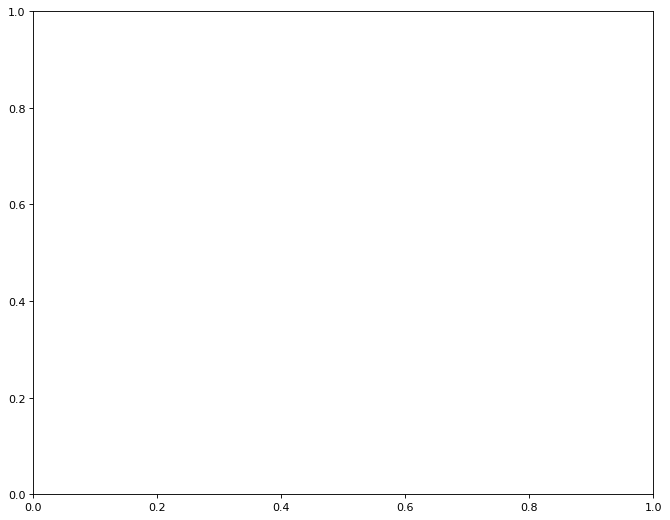

In [28]:
# Analyze hint frequencies
hints = list(C.keys())
hint_word_freq = [len(C[h]) for h in hints]
hint_data = sorted(list(zip(hint_word_freq, hints)),reverse=True)
hints = [h[1] for h in hint_data]
hint_word_freq= [h[0] for h in hint_data]

figure(num=None, figsize=(10, 8), dpi=80)
plt.barh(hints, hint_word_freq)
plt.title('Number of words before hint')
plt.show()

In [29]:
# Take a better look at the top 5 hints
n_hints = 5
for h in hints[:n_hints]:
    words = C[h]
    # counting and sorting by frequencies
    freq = []
    for w in words:
        freq.append(words.count(w))

    wordfreq = pd.DataFrame({'words': words, 'freq': freq})
    wordfreq = wordfreq.drop_duplicates()
    wordfreq = wordfreq.sort_values(by="freq", ascending=False)
    wordfreq = wordfreq.reset_index(drop=True)

    # plot the results (unfiltered)
    n_words = 20
    figure(num=None, figsize=(10, 8), dpi=80)
    plt.barh(wordfreq['words'][:n_words], wordfreq['freq'][:n_words])
    plt.title('(Unfiltered) most common words by kids before hint' + h)
    plt.show()

TypeError: unhashable type: 'list'